In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random

# Custom Dataset to include original, flipped, and conditionally augmented flipped images
class AugmentedDataset(Dataset):
    def __init__(self, dataset, additional_transforms=None, augment_prob=0.5):
        """
        Args:
            dataset: The original dataset (e.g., ImageFolder).
            additional_transforms: Additional transformations to apply.
            augment_prob: Probability of applying secondary transformations to flipped images.
        """
        self.dataset = dataset
        self.additional_transforms = additional_transforms
        self.augment_prob = augment_prob

    def __len__(self):
        # Double the dataset size (original + flipped)
        return len(self.dataset) * 2

    def __getitem__(self, idx):
        original_idx = idx % len(self.dataset)  # Get the original image index
        is_flipped = idx >= len(self.dataset)  # Check if it's a flipped image

        image, label = self.dataset[original_idx]

        # Apply horizontal flip if needed
        if is_flipped:
            image = transforms.functional.hflip(image)

            # Randomly apply secondary transformations
            if random.random() < self.augment_prob and self.additional_transforms:
                image = self.additional_transforms(image)

        return image, label


# Define transformations
transform_original = transforms.Compose([
    transforms.ToTensor(),
])

# Define additional transformations for flipped images
additional_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Random resized crop  # Randomly convert to grayscale
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Gaussian blur
    transforms.Lambda(lambda img: torch.clamp(img + torch.randn_like(img) * 0.05, 0.0, 1.0))  # Brightness noise
])

# Load original dataset
all_data_path = "/kaggle/input/fire-not-fire/dl2425_challenge_dataset/train"
original_dataset = datasets.ImageFolder(root=all_data_path, transform=transform_original)

# Create the augmented dataset
augmented_dataset = AugmentedDataset(
    original_dataset,
    additional_transforms=additional_transforms,
    augment_prob=0.7  # 70% of flipped images will have secondary transformations
)

# Optimize DataLoader settings
train_loader = DataLoader(
    augmented_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,  # Adjust based on your CPU cores
)

# Verify the DataLoader
print(f"Number of training samples (including flipped): {len(train_loader.dataset)}")


Number of training samples (including flipped): 21852


In [3]:
# Combine both datasets into one for splitting
all_data_path = "/kaggle/input/fire-not-fire/dl2425_challenge_dataset/val"
categories = ["0", "1"]

# Define transformations (resize to 224x224 and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert image to PyTorch tensor
])

# Load the dataset
dataset = datasets.ImageFolder(root=all_data_path, transform=transform)


# Create DataLoader for train and test sets
val_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Verify the dataloaders
print(f"Number of training samples: {len(val_loader.dataset)}")

Number of training samples: 3121


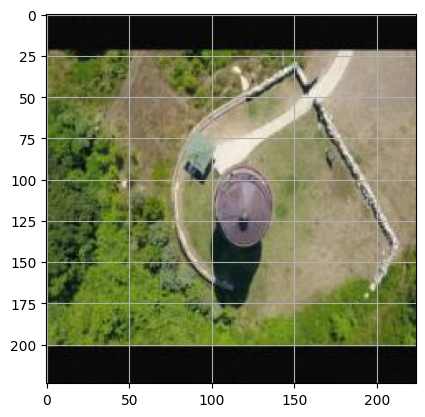

torch.Size([3, 224, 224]) tensor(0)


In [4]:
for batch in train_loader:
    # Plot the first image in the batch
    image_tensor = batch[0][0]
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to H x W x C for plotting
    plt.imshow(image)
    plt.grid(True)
    plt.axis('on')
    plt.show()
    print (image_tensor.shape, batch[1][0])
    break  # Display only one image

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        # use standard CE loss without reducion as basis
        self.CE = nn.CrossEntropyLoss(reduction='none',)
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        '''
        input (B, N)
        target (B)
        '''
        CE_loss = self.CE(input, target)
        pt = torch.exp(-CE_loss) # don't forget the minus here
        focal_loss = (1-pt)**self.gamma * CE_loss

        # apply class weights
        if self.alpha != None:
            focal_loss *= self.alpha.gather(0, target)
        
        if self.reduction == 'mean':
            focal_loss = focal_loss.mean()
        elif self.reduction == 'sum':
            focal_loss = focal_loss.sum()
        return focal_loss

In [6]:
resnet = torchvision.models.resnet34(weights="ResNet34_Weights.DEFAULT").to(device)
resnet.fc = nn.Linear(512,1024)

class lll(nn.Module):
    """Some Information about MyModule"""
    def __init__(self, backbone):
        super(lll, self).__init__()
        self.linear = nn.Linear(1024,512)
        self.linear2 = nn.Linear(512,2)
        self.backbone = backbone
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.backbone(x))
        x = self.dropout(x)
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        x = self.linear2(x)



        return x
    
head= lll(resnet).to(device)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


In [7]:
#make 5 epochs at a time diminishing the learning rate from lr=0.0001 to lr=0.000001
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs.to(device))  # Forward pass
            loss = criterion(outputs, labels.to(device))  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")



# Train the model
optimizer = optim.SGD(head.parameters(), lr=0.00001)
train_model(head,train_loader, optimizer, criterion, num_epochs=10)
#optimizer = optim.SGD(head.parameters(), lr=0.01)
#train_model(head,train_loader, optimizer, criterion)
#optimizer = optim.SGD(head.parameters(), lr=0.001)
#train_model(head,train_loader, optimizer, criterion)
#optimizer = optim.SGD(head.parameters(), lr=0.0001)
#train_model(head,train_loader, optimizer, criterion)

Epoch 1/10, Loss: 0.6954347069500483
Epoch 2/10, Loss: 0.6937281311604014
Epoch 3/10, Loss: 0.6913556428680643
Epoch 4/10, Loss: 0.6887152482543075
Epoch 5/10, Loss: 0.6864661454108724
Epoch 6/10, Loss: 0.6828690223526537
Epoch 7/10, Loss: 0.6803284357165733
Epoch 8/10, Loss: 0.680357167246746
Epoch 9/10, Loss: 0.6775090812939649
Epoch 10/10, Loss: 0.6738522450129191


In [8]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
        print(f"Test Accuracy: {100 * correct / total}%")

test_model(head, val_loader)

Test Accuracy: 62.512015379686%


In [9]:
#checkpoint = {'model': lll(resnet),
#              'state_dict': head.state_dict(),
#              'optimizer' : optimizer.state_dict()}

#torch.save(checkpoint, 'checkpoint.pth')

In [10]:
"""def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True

    model.eval()
    return model

head = load_checkpoint('checkpoint.pth').to(device)"""

"def load_checkpoint(filepath):\n    checkpoint = torch.load(filepath)\n    model = checkpoint['model']\n    model.load_state_dict(checkpoint['state_dict'])\n    for parameter in model.parameters():\n        parameter.requires_grad = True\n\n    model.eval()\n    return model\n\nhead = load_checkpoint('checkpoint.pth').to(device)"